In [1]:
#Reading Data
import json
import numpy as np
import pandas as pd   
ice = pd.read_json('train.json')
test = pd.read_json('test.json')

In [2]:
#Replace missing values in incidence angle by 0.
ice.inc_angle = ice.inc_angle.replace('na', 0)
ice.inc_angle = ice.inc_angle.astype(float).fillna(0.0)

In [3]:
#Store the bands of the training set in two different arrays.
band1 = []
band2 = []

for i in range(1604):
    band1.append(np.reshape(ice.iloc[i,0],(75,75)))
    band2.append(np.reshape(ice.iloc[i,1],(75,75)))



In [4]:
##Store the bands of the testing set in two different arrays.

test_band1 = []
test_band2 = []

for i in range(8424):
    test_band1.append(np.reshape(test.iloc[i,0],(75,75)))
    test_band2.append(np.reshape(test.iloc[i,1],(75,75)))

In [5]:
#Converting bands of training and testing sets to type float.
band1 = np.array(band1,dtype='f')
band2 = np.array(band2,dtype='f')
test_band1 = np.array(test_band1,dtype='f')
test_band2 = np.array(test_band2,dtype='f')

In [6]:
#Take Average of both bands of training set and store it in a new variable. 
new_band = []
for i in range(1604):
    new_band.append((band1[i] +band2[i])/2)
new_band = np.array(new_band,dtype='f')
new_band.shape

(1604, 75, 75)

In [7]:
#Take Average of both bands of testing set and store it in a new variable. 

test_new_band=[]
for i in range(8424):
    test_new_band.append((test_band1[i] + test_band2[i])/2)
test_new_band = np.array(test_new_band,dtype='f')
test_new_band.shape

(8424, 75, 75)

In [8]:
#Changing Sign

for i in range(1604):
    new_band[i] = np.negative(new_band[i])
    band1[i] = np.negative(band1[i])
    band2[i] = np.negative(band2[i])
for i in range(8424):
    test_new_band[i] = np.negative(test_new_band[i])
    test_band1[i] = np.negative(test_band1[i])
    test_band2[i] = np.negative(test_band2[i])

In [9]:
#Subtracting each column of each pixel by the max value
for i in range(1604):
    for j in range(75):
        new_band[i][j] = np.max(new_band[i][j]) - new_band[i][j]
        band1[i][j] = np.max(band1[i][j]) - band1[i][j]
        band2[i][j] = np.max(band2[i][j]) - band2[i][j]
for i in range(8424):
    for j in range(75):
        test_new_band[i][j] = np.max(test_new_band[i][j]) - test_new_band[i][j]
        test_band1[i][j] = np.max(test_band1[i][j]) - test_band1[i][j]
        test_band2[i][j] = np.max(test_band2[i][j]) - test_band2[i][j]

In [10]:
from sklearn.preprocessing import normalize
for i in range(1604):
    new_band[i] = normalize(new_band[i], axis=1, norm='l2')
    band1[i] = normalize(band1[i],axis=1,norm='l2')
    band2[i] = normalize(band2[i],axis=1,norm='l2')
for i in range(1604):
    test_new_band[i] = normalize(test_new_band[i], axis=1, norm='l2')
    test_band1[i] = normalize(test_band1[i], axis=1, norm='l2')
    test_band2[i] = normalize(test_band2[i], axis=1, norm='l2')

In [11]:
#Sharpening gives the best log loss value of 0.4916
sharp1 = []
sharp2 = []
sharp3 = []
from scipy import signal
sharpening_kernel = np.array([[0,1,0],[-1,-4,1],[0,1,0]])
#fig = plt.figure(1,figsize=(15,15))
for i in range(1604):
    #ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(band1[i],sharpening_kernel,mode='valid')
    sharp1.append(arr)
    arr = signal.convolve2d(band2[i],sharpening_kernel,mode='valid')
    sharp2.append(arr)
    arr = signal.convolve2d(new_band[i],sharpening_kernel,mode='valid')
    sharp3.append(arr)



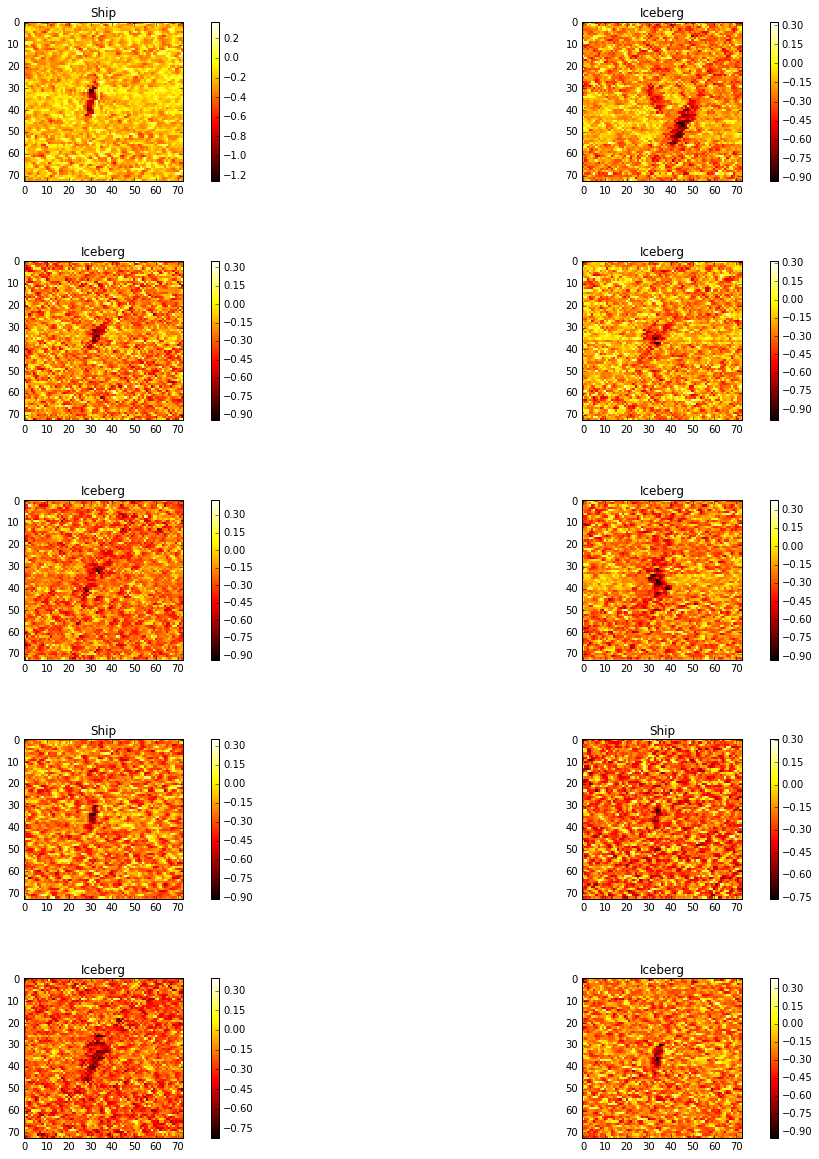

In [13]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import random

#Randomly generate 10 unique numbers from the range of 0-1604
random_int = random.sample(range(0,1604),10)
object_class = np.array(ice.iloc[random_int,4])
class_label=[]
for i in range(len(object_class)):
    if object_class[i] == 0:
        class_label.append("Ship")
    else:
        class_label.append("Iceberg")
i=0
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace = 0.5, wspace=.001)

for image in random_int:
    ax = fig.add_subplot(5,2,i+1)
    im = plt.imshow(sharp3[image], cmap='hot', interpolation='none')
    ax.imshow(sharp3[image], cmap='hot', interpolation='none')
    plt.title(class_label[i])
    i+=1
    cbar = plt.colorbar(im)
plt.savefig("Lsplacian")

In [45]:
sharp3 = np.array(sharp3)
sharp3 = sharp3.reshape(sharp3.shape[0],73,73,1)
sharp3.shape

(1604, 73, 73, 1)

In [46]:
sharp_test = np.array(sharp_test)
sharp_test = sharp_test.reshape(sharp_test.shape[0],73,73,1)
sharp_test.shape

(8424, 73, 73, 1)

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils import plot_model
import pydot
K.set_image_dim_ordering('tf')

np.random.seed(1000)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(75,75,1),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,( 3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,( 3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalMaxPooling2D())
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(sharp3[:802],np_utils.to_categorical(ice.iloc[:802,4]),validation_data=(sharp3[802:],np_utils.to_categorical(ice.iloc[802:,4])), 
          batch_size=32, nb_epoch=100, verbose=1,shuffle = True)
plot_model(model, to_file='model.png')


Train on 802 samples, validate on 802 samples
Epoch 1/100
802/802 [==============================] - 7s - loss: 0.6927 - acc: 0.5050 - val_loss: 0.6990 - val_acc: 0.4302
Epoch 2/100
802/802 [==============================] - 7s - loss: 0.6888 - acc: 0.5349 - val_loss: 0.6800 - val_acc: 0.6671
Epoch 3/100
802/802 [==============================] - 7s - loss: 0.6646 - acc: 0.6284 - val_loss: 0.6514 - val_acc: 0.6322
Epoch 4/100
802/802 [==============================] - 7s - loss: 0.6194 - acc: 0.6683 - val_loss: 0.5629 - val_acc: 0.7357
Epoch 5/100
802/802 [==============================] - 7s - loss: 0.5523 - acc: 0.7244 - val_loss: 0.5426 - val_acc: 0.7170
Epoch 6/100
802/802 [==============================] - 7s - loss: 0.5504 - acc: 0.7282 - val_loss: 0.5670 - val_acc: 0.7007
Epoch 7/100
802/802 [==============================] - 7s - loss: 0.5071 - acc: 0.7581 - val_loss: 0.5102 - val_acc: 0.7519
Epoch 8/100
802/802 [==============================] - 7s - loss: 0.4864 - acc: 0.7681

In [62]:
final_prediction = model.predict_proba(vertical_stack_test,verbose=1)


8424/8424 [==============================] - 72s    


In [63]:
result=pd.read_csv('sample_iceberg.csv')
predi = pd.DataFrame(final_prediction)
nresult=pd.DataFrame()
nresult['id'] = test['id']
nresult['is_iceberg'] = predi.iloc[:,1]
nresult.to_csv('result.csv', index=False)


'"predi.columns=[\'0\',\'is_iceberg\']\nresult.iloc[:,1] = predi.iloc[:,1]\nprint(result)'

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='poly')
clf.fit(rand[:1400],ice.iloc[:1400,4])

accuracy_score(clf.predict(rand[1400:]),ice.iloc[1400:,4])